In [9]:
# !pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms pylatexenc

In [10]:
# !pip list | grep qiskit

In [11]:
import warnings
warnings.filterwarnings('ignore')

## **Variational Classification**

<br>

In this module, we introduce **variational algorithms**, describe how a **Variational Quantum Classifier (VQC)** works, and show how to train it using hybrid quantum-classical optimization.

---



### **Variational Algorithms**

Variational algorithms include methods such as:
* **Variational Quantum Eigensolver (VQE)**
* **Quantum Approximate Optimization Algorithm (QAOA)**

These are **near-term hybrid quantum-classical algorithms**, well-suited for today’s noisy quantum devices.

<br>

A variational algorithm uses:
1. A **parameterized quantum circuit** (ansatz) $U(\theta)$
2. A **cost function** $C(\theta)$
3. A **classical optimizer** to update parameters

The quantum circuit prepares:
$$
|\psi(\theta)\rangle = U(\theta)|0\rangle
$$

The classical computer adjusts $\theta$ based on measurement results to minimize $C(\theta)$.

---

### **Variational Quantum Classifier (VQC)**

The variational quantum classifier applies variational methods to binary classification.

Given:
* Input feature vectors $\vec{x}_i$
* Binary labels $y_i \in \{0, 1\}$

The classifier prepares:
$$
|\psi(\vec{x}_i; \vec{\theta})\rangle = U_W(\vec{\theta}) \, U_\phi(\vec{x}_i)|0\rangle
$$

where:
* $U_\phi(\vec{x}_i) =$ **data encoding circuit**
* $U_W(\vec{\theta}) =$ **variational trainable circuit**

<br>

After measurement, we obtain a bitstring of length $n$.
A Boolean function $f: \{0, 1\}^n \rightarrow \{0, 1\}$ converts the bitstring into a predicted label.

<br>

A common choice is the **parity function**.

---

#### **VQC manual implementation**

---


<br>

**1. load the dataset**

---

In [42]:

import numpy as np
from qiskit_machine_learning.datasets import ad_hoc_data

n_dim = 2
x_train, y_train, x_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=n_dim,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)


<br>

**2. build classification circuit**

 - use ZZFeatureMap as data encoding
 - use TwoLocal as variational circuit

---

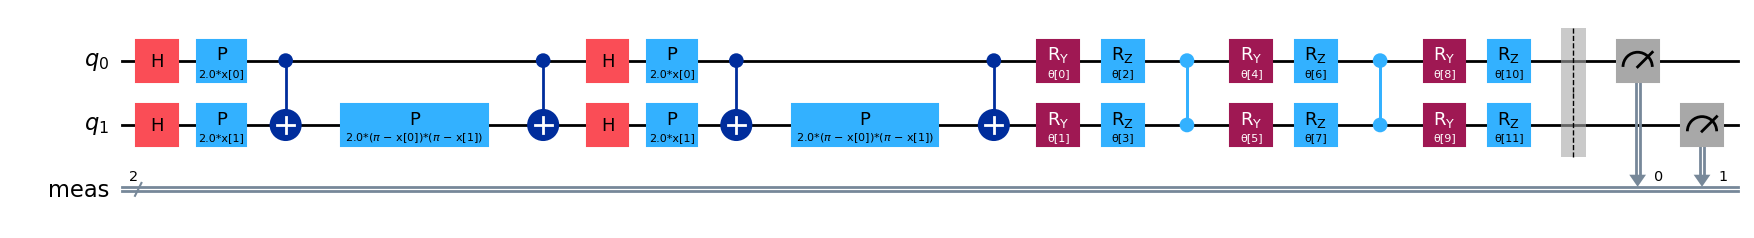

In [43]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

feature_map = ZZFeatureMap(feature_dimension=n_dim, reps=2)
var_form = TwoLocal(
    num_qubits=n_dim,
    rotation_blocks=['ry', 'rz'],
    entanglement_blocks='cz',
    reps=2
)

adhoc_circuit = feature_map.compose(var_form)
adhoc_circuit.measure_all()
adhoc_circuit = adhoc_circuit.decompose()
adhoc_circuit.draw(output='mpl')


<br>

**3. assign parameters to build circuit instance**

---

In [44]:
def circuit_instance(data, variational):
  params = {}

  for i, p in enumerate(feature_map.ordered_parameters):
    params[p] = data[i]

  for i, p in enumerate(var_form.ordered_parameters):
    params[p] = variational[i]

  return adhoc_circuit.assign_parameters(params)


<br>

**4. parity based label assignment**

---


In a **Variational Quantum Classifier (VQC)**, the measurement output from the quantum circuit is a bitstring $z$ of length $n$ (e.g., $00, 01, 10, 11$).

To convert this bitstring into a binary class label $y \in \{0, 1\}$, we apply the **parity function** $f(z)$.

<br>

**The Parity Rule**
<br>The label is determined by the parity of the Hamming weight (the number of $1$s) of the bitstring:

$$
f(z) = \left( \sum_{i=0}^{n-1} z_i \right) \pmod 2
$$

This results in the following mapping:
* **Even number of 1s** $\rightarrow$ **Class 0**
* **Odd number of 1s** $\rightarrow$ **Class 1**

<br>

**Why use Parity?**
<br>This method is widely used in quantum machine learning because:
1.  **Simplicity:** It is computationally trivial to calculate classically.
2.  **Scalability:** It applies consistently regardless of the number of qubits ($n$).
3.  **Robustness:** It distributes information globally across all qubits, rather than relying on a single qubit's state.
4.  **Physical Alignment:** Many quantum feature maps naturally generate interference patterns based on even or odd excitations.

In [45]:
def parity(bitstring):
  hamming_weight = sum(int(i) for i in bitstring)
  return (hamming_weight+1) % 2

# function to convert measurement to label probabilities
def label_prob(results):
  shots = sum(results.values())
  probs = { 0 : 0, 1 : 0}

  for bitstring, counts in results.items():
    label = parity(bitstring)
    probs[label] += counts/shots

  return probs


<br>

**5. classifying new data points**

---

In [47]:

from qiskit_aer import AerSimulator
from qiskit import transpile

def classification_probs(data, variational):
  circuit = [circuit_instance(d, variational) for d in data]

  backend = AerSimulator()
  transpiled_circuit = transpile(circuit, backend)
  job = backend.run(transpiled_circuit)
  results = job.result()

  classification = [ label_prob(results.get_counts(c)) for c in circuit]
  return classification


<br>

**6. define cross entropy**

---

**Cross-Entropy Loss**
<br>Given a true label $y$ (expected) and a predicted probability distribution $P$, the loss $\mathcal{L}$ is defined as:

$$
\mathcal{L}(y, P) = -\ln( P(y) + \epsilon)
$$

* **$P(y)$:** The probability assigned by the quantum circuit to the *correct* class.
* **Logarithm:** We take the negative natural log.
    * If $P(y) \approx 1$ (confident & correct), the loss is near **0**.
    * If $P(y) \approx 0$ (wrong), the loss **explodes to infinity**.
* **Epsilon ($10^{-10}$):** We add a tiny number $\epsilon = 10^{-10}$ inside the log to prevent mathematical errors, since $\ln(0) = -\infty$.



In [48]:
def cross_entropy_loss(classification, expected):
  p = classification.get(expected)
  return -np.log( p + 1e-10)


<br>

**7. define cost function**

---

**The Cost Function**
<br>The total cost (or objective function) $C(\theta)$ is the average of the individual losses for all $M$ training examples:

$$
C(\theta) = \frac{1}{M} \sum_{i=1}^{M} \mathcal{L}(y_i, P(x_i; \theta))
$$

* **Step 1:** Get probabilities for all data points (classification_probs).
* **Step 2:** Sum the cross-entropy loss for each point.
* **Step 3:** Divide by the number of data points ($M$) to normalize the result.

In [49]:

def cost_functon(data, labels, variational):
  classifications = classification_probs(data, variational)

  cost = 0
  for ind, clf in enumerate(classifications):
    cost += cross_entropy_loss(clf, labels[ind])

  cost /= len(data)
  return cost

<br>

**8. Optimize using SPSA**

---

In [52]:
from qiskit_algorithms.optimizers import SPSA

class OptimLog:
  def __init__(self):
    self.evaluations = []
    self.parameters = []
    self.costs = []

  def update(self, evaluation, param, cost, _stepsize, _accept):
    self.evaluations.append(evaluation)
    self.parameters.append(param)
    self.costs.append(cost)


log = OptimLog()
optimizer = SPSA(maxiter=200, callback=log.update)


In [53]:
# define objective function
def objective_func(variational):
  return cost_functon(x_train, y_train, variational)

# define initial point
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

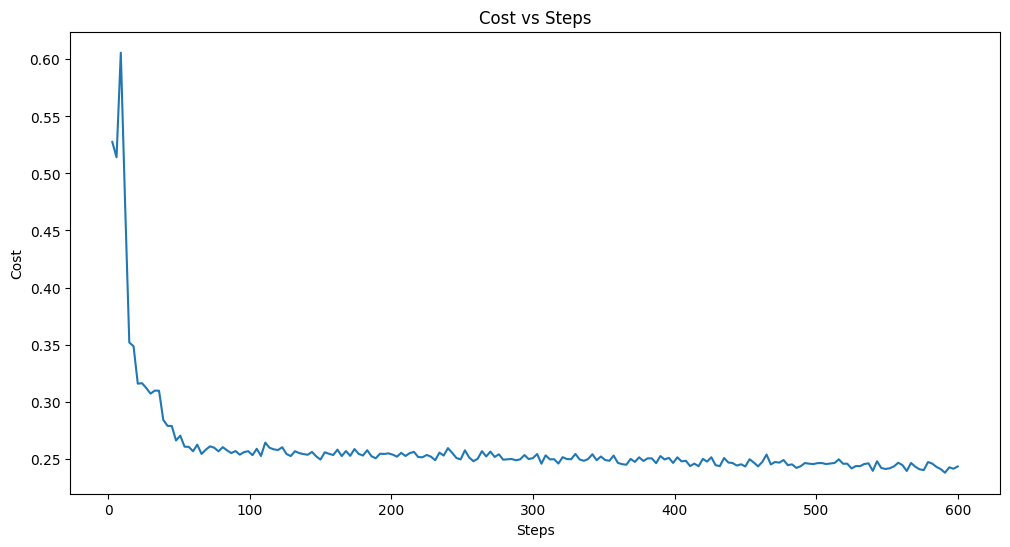

In [54]:
# run the optimizer
result = optimizer.minimize(
    objective_func,
    initial_point
)

opt_var = result.x
opt_value = result.fun

# plot the cost function
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title('Cost vs Steps')
plt.show()


<br>

**9. test the trained classifier**

---

In [55]:
def test_classification(data, labels, variational):
  clf_probs = classification_probs(data, variational)
  predictions = [0 if p[0] >= p [1] else 1 for p in clf_probs]
  accuracy = 0
  for ind, p in enumerate(predictions):
    if predictions[ind] == labels[ind]:
      accuracy += 1
  accuracy /= len(data)
  return accuracy, predictions

test_accuracy, predictions = test_classification(x_test, y_test, opt_var)
print(test_accuracy)


1.0


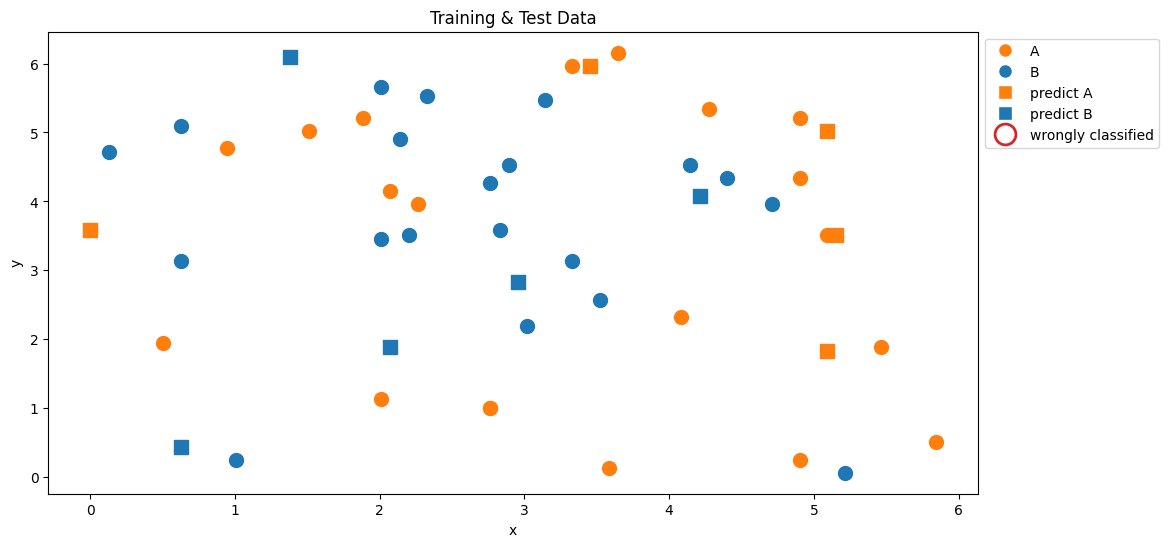

In [56]:
from matplotlib.lines import Line2D
plt.figure(figsize=(12, 6))

for feature, label in zip(x_train, y_train):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(x_test, y_test, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### **VQC using inbuilt functions**

---

In [29]:
# implementation of VQC
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])



In [31]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

log = OptimLog()
optimizer = SPSA(maxiter=100, callback=log.update)

vqc = VQC(
    feature_map=feature_map,
    ansatz=var_form,
    loss='cross_entropy',
    optimizer=optimizer,
    initial_point=initial_point,
    sampler=sampler
)

result = vqc.fit(x_train, y_train_oh)

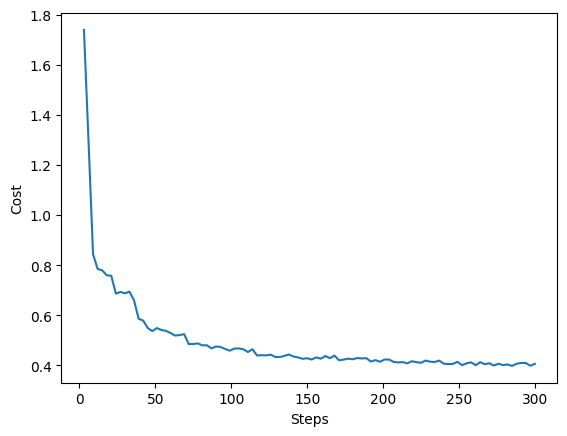

In [32]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [33]:
vqc.score(x_test, y_test_oh)

0.7

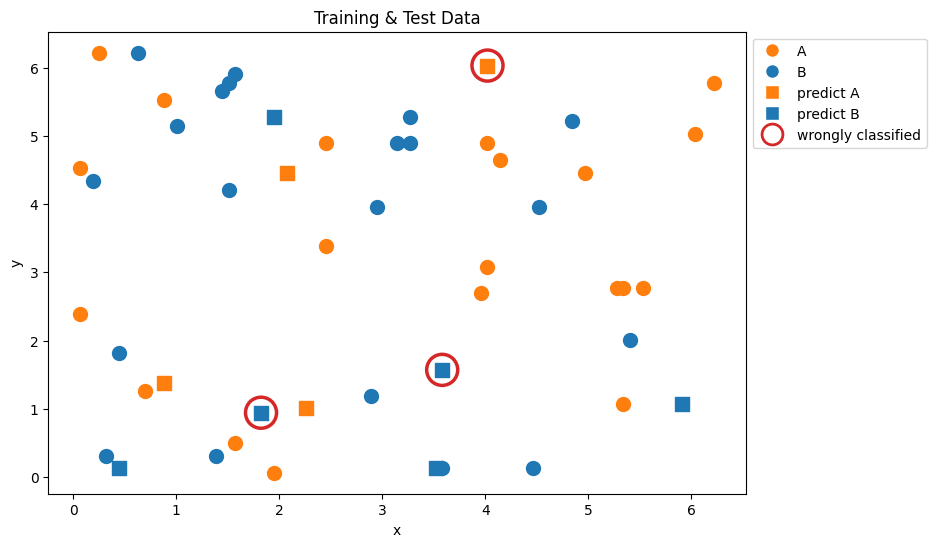

In [34]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(x_train, y_train_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(x_test, y_test_oh,
                                vqc.predict(x_test)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()